In [75]:
import pandas as pd

pd.Index([1,2,3]).difference(pd.Index([2,3,4]))

Index([1], dtype='int64')

In [113]:
import re
import sys
import requests
import numpy as np
import pandas as pd
from pathlib import Path
from urllib import parse

sys.path.append(str(Path.cwd().parent / "scripts"))

from build_base import build_sp_register

year_file = Path.cwd().parent / "data" / "year-ahead-constraint-limits.csv"
two_year_file = Path.cwd().parent / "data" / "24-months-ahead-constraint-limit_060924.csv"


def build_boundary_flow_limits(date_range):

    # request to national grid ESO is made in London time
    start = (
        date_range[0]
        .tz_convert('Europe/London')
    )
    end = (
        date_range[-1]
        .tz_convert('Europe/London')
    )

    sql_query = (
        '''SELECT COUNT(*) OVER () AS _count, * FROM "38a18ec1-9e40-465d-93fb-301e80fd1352"'''+
        ''' WHERE "Date (GMT/BST)" >= '{}' '''.format(start.strftime("%Y-%m-%d %H:%M:%S")) +
        '''AND "Date (GMT/BST)" <= '{}' '''.format(end.strftime("%Y-%m-%d %H:%M:%S")) +
        '''ORDER BY "_id" ASC LIMIT 1000'''
    )

    params = {'sql': sql_query}

    response = requests.get(
        'https://api.nationalgrideso.com/api/3/action/datastore_search_sql',
        params=parse.urlencode(params)
        )

    data = response.json()["result"]

    df = (
        pd.DataFrame(data["records"])
        .set_index("Constraint Group")
        [["_count", "Limit (MW)", "Flow (MW)", "Date (GMT/BST)"]]
        .rename(columns={
            "Limit (MW)": "limit",
            "Flow (MW)": "flow",
            "Date (GMT/BST)": "date",
            })
        .drop(columns=['_count'])
    )

    boundaries = pd.Index(['SSE-SP', 'SCOTEX', 'SSHARN', 'FLOWSTH', 'SEIMP'])

    df = df.set_index('date', append=True)['limit'].unstack().T
    df[df >= 15_000] = np.nan

    df.index = (
        pd.to_datetime(df.index)
        .tz_localize('Europe/London')
        .tz_convert('UTC')
    )

    number_split = lambda x: re.split(r'\d', x, maxsplit=1)[0]
    def match_and_cut(index, true_names):

        new_index = pd.Index(map(number_split, index)).intersection(true_names)
        old_index = pd.Index([i for i in index if number_split(i) in new_index])

        return {
            old: new for new, old in zip(new_index, old_index)
        }

    renamer = match_and_cut(df.columns, boundaries)
    
    df = (
        pd.concat((
            df[renamer.keys()].rename(columns=renamer),
            pd.DataFrame(
                np.nan, index=df.index,
                columns=boundaries.difference(renamer.values())
                )
        ), axis=1).loc[:, boundaries]
    )

    return df




day = '2024-10-05'

sp_register = build_sp_register(day)
date_range = sp_register.index

df1 = build_boundary_flow_limits(date_range)
df1.head()

,SSE-SP,SCOTEX,SSHARN,FLOWSTH,SEIMP
date,,,,,
2024-10-04 23:00:00+00:00,1900,4750,8500,9000,NaN
2024-10-04 23:30:00+00:00,1900,4750,8500,9000,NaN
2024-10-05 00:00:00+00:00,1900,4750,8500,9000,NaN
2024-10-05 00:30:00+00:00,1900,4750,8500,9000,NaN
2024-10-05 01:00:00+00:00,1900,4750,8500,9000,NaN


In [126]:
ya = pd.read_csv(year_file, parse_dates=['Week'], index_col=0)
ta = pd.read_csv(two_year_file)

ta.index = ta.apply(
    lambda row: pd.Timestamp(str(row.YEAR)) + row['Week No'] * pd.Timedelta(weeks=1)
    , axis=1
    )

In [125]:
ya.sort_index().tail()

,B6 - SCOTEX,B6 import - HARETORIM,B5 - SSE+GRM,B2 - SSEN-S,B4 - SSE-SP2,B5 - NKILGRMO,SW1 - SWALEX,LE1 - SEIMPPR2,no equivalent - HUMBEREX,B15 - ESTEX,B7 - SSHARN3
Week,,,,,,,,,,,
2022-02-28,4650,3500,2700,2950,2700,1900,3200,7000,7000,7500,6600
2022-03-07,4650,3500,2700,2950,2700,1900,3200,6200,7000,6200,7000
2022-03-14,4650,3500,2700,2950,2700,1900,3200,6200,6700,6000,7000
2022-03-21,4650,3500,2700,2950,2700,1900,3200,6200,6700,5700,7000
2022-03-28,4650,3500,2700,2950,2700,1900,3200,6500,6700,5700,6800


In [128]:
ta.sort_index()

,YEAR,Week No,DRESHEX1,ESTEX,FLOWSTH,GM+ SNOW5A,NKILGRMO,SCOAST2,SCOTEX ASACS,SEIMPPR2,SSE+GRM,SSEN-S,SSE-SP2,SSHARN3 (With HVDC)
2024-01-08,2024,1,9286,8772,11782,4132,2800,7848,5864,9230,2800,2943,3283,8947
2024-01-15,2024,2,9143,8772,11782,4132,2700,7848,5864,9230,2700,2943,3283,8815
2024-01-22,2024,3,8711,8461,11573,4132,2800,7848,5864,8918,2800,2943,3283,8682
2024-01-29,2024,4,9114,8630,11573,4132,2800,7848,5864,9003,2800,2943,3283,8762
2024-02-05,2024,5,8050,8630,11391,4132,2800,7848,5864,9173,2800,2943,3283,8735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-09-10,2026,36,99999,4900,10500,5300,2310,4450,4600,5750,2330,2038,2213,7100
2026-09-17,2026,37,99999,4500,10850,4800,2310,4550,4600,7500,2320,2038,2213,7050
2026-09-24,2026,38,99999,5475,9800,3875,2310,5350,4650,7275,2250,2038,2213,6150
2026-10-01,2026,39,99999,5475,9425,3675,2310,5350,4700,7300,2280,2038,2213,6100


In [92]:
a = pd.read_csv(
    Path.cwd().parent / 'data' / '24-months-ahead-constraint-limit_060924.csv'
)

In [121]:
a.sort_index()

,YEAR,Week No,DRESHEX1,ESTEX,FLOWSTH,GM+ SNOW5A,NKILGRMO,SCOAST2,SCOTEX ASACS,SEIMPPR2,SSE+GRM,SSEN-S,SSE-SP2,SSHARN3 (With HVDC)
2024-01-08,2024,1,9286,8772,11782,4132,2800,7848,5864,9230,2800,2943,3283,8947
2024-01-15,2024,2,9143,8772,11782,4132,2700,7848,5864,9230,2700,2943,3283,8815
2024-01-22,2024,3,8711,8461,11573,4132,2800,7848,5864,8918,2800,2943,3283,8682
2024-01-29,2024,4,9114,8630,11573,4132,2800,7848,5864,9003,2800,2943,3283,8762
2024-02-05,2024,5,8050,8630,11391,4132,2800,7848,5864,9173,2800,2943,3283,8735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-09-10,2026,36,99999,4900,10500,5300,2310,4450,4600,5750,2330,2038,2213,7100
2026-09-17,2026,37,99999,4500,10850,4800,2310,4550,4600,7500,2320,2038,2213,7050
2026-09-24,2026,38,99999,5475,9800,3875,2310,5350,4650,7275,2250,2038,2213,6150
2026-10-01,2026,39,99999,5475,9425,3675,2310,5350,4700,7300,2280,2038,2213,6100


In [ ]:
from io import StringIO
from tqdm import tqdm

filler = '060924'
url = 'https://api.neso.energy/dataset/d515b4a9-60a1-489c-a126-004efc04f121/resource/3c359e33-3dac-4bdd-87d1-efbf4cbc2f07/download/24-months-ahead-constraint-limit_{}.csv'

for date in tqdm(pd.date_range('2023', '2025', freq='d')):
    response = requests.get(url.format(date.strftime('%y%m%d')))
    if response.status_code != 200:
        print(date)
        break



response = requests.get(url.format(filler))
print(response.status_code)
df = pd.read_csv(StringIO(response.text))

df

  3%|▎         | 25/732 [00:43<20:36,  1.75s/it]

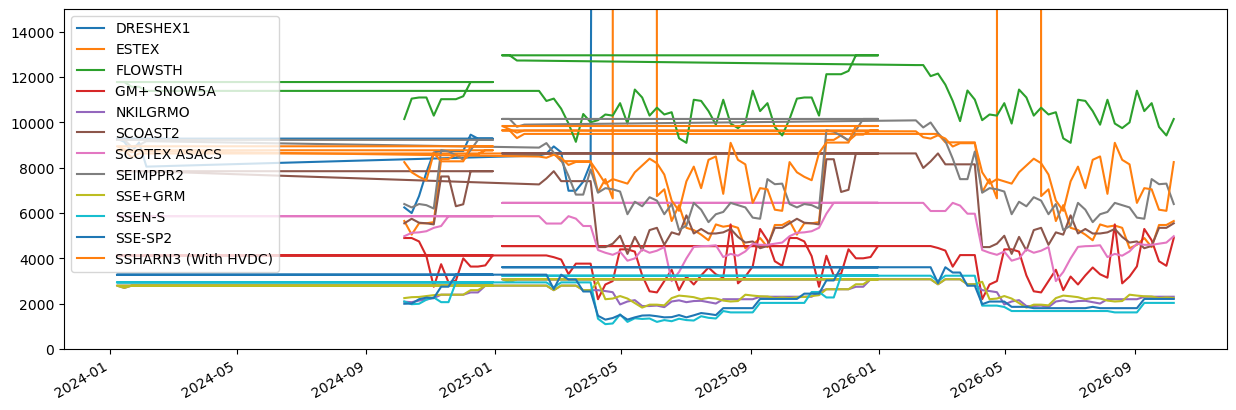

In [119]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

a.drop(columns=['YEAR', 'Week No']).plot(ax=ax)
ax.set_ylim(0, 15000)

plt.show()